<a href="https://colab.research.google.com/github/seismic2020/WG1-P4/blob/master/WG1P4_PropensityScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Propensity score matching
# 03.02.20/ Updated 03.20.20

# We will use the datasets from part 2: SEISMIC_AP_RQ1/2: chem_tookap; chemap_unique; physap_unique
# The codes should be similar across chem, physics, and bio | feel free to update the codes

# We are using inverse probability weight (IPW). The idea is to assign greater weights for those less likely to receive treatment (i.e., AP real skip)
# This is because in the presence of confounding, estimate for the average treated and control outcomes may be biased
# (1) Calculate the propensity to be in the treatment (e.g., skip AP) from a set of covariates. We can use logistic regression.
# (2) Individuals with a lower propensity score (e.g., to skip AP) will receive larger weight
# More details about propensity score matching methods can be found here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
# A demonstration of WeightIt for IPW: https://cran.r-project.org/web/packages/WeightIt/vignettes/WeightIt_A0_basic_use.html

# Please tag @    ,@     @    if you have questions that need to be resolved.

In [0]:
# Load libraries
install.packages("pacman")
pacman::p_load("WeightIt", "cobalt", "survey", "jtools", "misaem")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [0]:
# Load data
chemap_unique <- read.csv("/Users/thicn/Documents/AP Skip/chemap_unique2.csv")
physap_unique <- read.csv("/Users/thicn/Documents/AP Skip/physap_unique2.csv")

In [0]:
names(chemap_unique)

[1] "X.2"                  "X.1"                  "X"                   
 [4] "st_id"                "studentid"            "apskipper_GChem1"    
 [7] "apskipper_Phys1"      "aptaker_Chem"         "apyear_Chem"         
[10] "apscore_Chem"         "aptaker_Mec"          "aptaker_Elec"        
[13] "apyear_Mec"           "apyear_Elec"          "apscore_Mec"         
[16] "apscore_Elec"         "coursecode"           "crs_name"            
[19] "crs_catalog"          "class_number"         "crs_sbj"             
[22] "level"                "newfresh"             "numgrade"            
[25] "gender"               "ethniccode"           "ethniccode_cat"      
[28] "ethniccode_cat2"      "firstgen"             "lowincomeflag"       
[31] "ellflag"              "international"        "hsgpa"               
[34] "hsgpa_z"              "bstsat1mathsr"        "bstsat1readsr"       
[37] "actenglsr"            "actmathsr"            "mathsr"              
[40] "englsr"               "crs_term"             "admitdate"           
[43] "enrl_from_cohort"     "yearsenrolled"        "cohort"              
[46] "stemmajor"            "chemNotSkipthoughEl"  "aprealskipper_GChem1"
[49] "physNotSkipthoughEl"  "aprealskipper_Phys1"

In [0]:
# Start with CHEMISTRY
# First, estimate weights using Average Treatment on the Treated (ATT) from a
# logistic regression model to predict aprealskipper_GChem1
# A caveat for the weighit command is it only works iwth complete data
chemap_unique_nomiss <- chemap_unique[complete.cases(chemap_unique$numgrade),]
head(chemap_unique_nomiss)
# Make sure the predictor factor is coded in factor
chemap_unique_nomiss$aprealskipper_GChem1 <- as.factor(chemap_unique_nomiss$aprealskipper_GChem1)
class(chemap_unique_nomiss$aprealskipper_GChem1)
table(chemap_unique_nomiss$aprealskipper_GChem1)

X.2,X.1,X,st_id,studentid,apskipper_GChem1,apskipper_Phys1,aptaker_Chem,apyear_Chem,apscore_Chem,...,crs_term,admitdate,enrl_from_cohort,yearsenrolled,cohort,stemmajor,chemNotSkipthoughEl,aprealskipper_GChem1,physNotSkipthoughEl,aprealskipper_Phys1
10,10,10,25,10006293,0,0,0,0,0,...,2015,F14,2,0.5,2014,2,0,0,0,0
95,95,95,51,10031543,0,0,0,0,0,...,2017,F16,2,0.5,2016,2,0,0,0,0
132,132,132,60,10041236,0,0,0,0,0,...,2013,F12,2,0.5,2013,2,0,0,0,0
153,153,153,64,10046297,0,0,0,0,0,...,2013,F12,2,0.5,2013,1,0,0,0,0
217,217,217,83,10062453,0,0,0,0,0,...,2017,F16,2,0.5,2016,2,0,0,0,0
263,263,263,107,10077745,0,0,0,0,0,...,2013,F12,2,0.5,2013,2,0,0,0,0


[1] "factor"


   0    1 
7490  133 

In [0]:
# Are our covariates imbalanced?
bal.tab(aprealskipper_GChem1 ~ factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        ethniccode_cat2 + hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term),
        data = chemap_unique_nomiss, estimand = "ATT", m.threshold = .05)

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Balance Measures
                           Type Diff.Un      M.Threshold.Un
factor(firstgen)_1       Binary -0.3094 Not Balanced, >0.05
factor(firstgen):<NA>    Binary  0.0052     Balanced, <0.05
factor(lowincomeflag)_2  Binary -0.1235 Not Balanced, >0.05
factor(gender)_1         Binary -0.2154 Not Balanced, >0.05
factor(gender):<NA>      Binary  0.0052     Balanced, <0.05
ethniccode_cat2          Binary  0.0183     Balanced, <0.05
hsgpa_z                 Contin.  0.6207 Not Balanced, >0.05
scale(mathsr)           Contin.  1.9024 Not Balanced, >0.05
scale(englsr)           Contin.  1.0562 Not Balanced, >0.05
factor(crs_term)_2013    Binary -0.1939 Not Balanced, >0.05
factor(crs_term)_2014    Binary -0.1796 Not Balanced, >0.05
factor(crs_term)_2015    Binary -0.0101     Balanced, <0.05
factor(crs_term)_2016    Binary  0.0859 Not Balanced, >0.05
factor(crs_term)_2017    Binary  0.2977 Not Balanced, >0.05

Balance tally for mean differences
                    count
Balanced, <0.05      

In [0]:
# Estimate weight; because we still have missing data, use stochastic approximation of the EM algorithm (SAEM) through the misaem package
# More details on SAEM: http://juliejosse.com/wp-content/uploads/2018/07/LectureNotesMissing.html
# Estimate = Average treatment for the treated
# method = propensity score to calculate weights
skip_weight <- weightit(aprealskipper_GChem1~factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        ethniccode_cat2 + hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), 
                      data=chemap_unique_nomiss, estimand="ATT", method="ps", missing = "saem")
skip_weight

A weightit object
 - method: "ps" (propensity score weighting)
 - number of obs.: 7623
 - sampling weights: none
 - treatment: 2-category
 - estimand: ATT (focal: 1)
 - covariates: factor(firstgen), factor(lowincomeflag), factor(gender), ethniccode_cat2, hsgpa_z, scale(mathsr), scale(englsr), factor(crs_term)

In [0]:
summary(skip_weight)

                 Summary of weights

- Weight ranges:

        Min                                  Max
treated   1                       ||      1.0000
control   0 |---------------------------| 1.3426

- Units with 5 greatest weights by group:
                                           
            124    157    241    383    395
 treated      1      1      1      1      1
           7301   5582   5499   3582     80
 control 0.6997 0.7399 0.7825 0.8872 1.3426

- Weight statistics:

        Coef of Var  MAD    Entropy
treated       0.000 0.00      0.000
control       3.104 1.38 -17717.321
overall       4.000 1.51  -9029.974

- Effective Sample Sizes:

            Control Treated
Unweighted 7490.000     133
Weighted    704.183     133

In [0]:
# Is our weight more balanced?
bal.tab(skip_weight, m.threshold = .05, disp.v.ratio=T) #much more balanced

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Call
 weightit(formula = aprealskipper_GChem1 ~ factor(firstgen) + 
    factor(lowincomeflag) + factor(gender) + ethniccode_cat2 + 
    hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), 
    data = chemap_unique_nomiss, method = "ps", estimand = "ATT", 
    missing = "saem")

Balance Measures
                            Type Diff.Adj     M.Threshold V.Ratio.Adj
prop.score              Distance  -0.0235                      1.0353
factor(firstgen)_1        Binary  -0.0033 Balanced, <0.05            
factor(firstgen):<NA>     Binary   0.0066 Balanced, <0.05            
factor(lowincomeflag)_2   Binary  -0.0120 Balanced, <0.05            
factor(gender)_1          Binary   0.0054 Balanced, <0.05            
factor(gender):<NA>       Binary   0.0059 Balanced, <0.05            
ethniccode_cat2           Binary   0.0063 Balanced, <0.05            
hsgpa_z                  Contin.  -0.0087 Balanced, <0.05      1.0206
scale(mathsr)            Contin.  -0.0086 Balanced, <0.05      0.7

In [0]:
# With weights estimated, estimate the treatment effect, using "survey" package
# Regression to predict grades in CHEM1B. 2c: Full sample, include AP score
chem.w <- svydesign(ids=~1, weights=get.w(skip_weight), data=chemap_unique_nomiss)
fitchem_2c <- svyglm(numgrade~factor(aprealskipper_GChem1)+apscore_Chem +
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat2) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chem.w)
coef(fitchem_2c)
#std_beta(fitchem_2c) # "sjstats" package; can't get it to load in jupyter notebook

(Intercept) factor(aprealskipper_GChem1)1 
                   2.67892131                    0.09941007 
                 apscore_Chem             factor(firstgen)1 
                   0.09310618                    0.05616176 
       factor(lowincomeflag)2               factor(gender)1 
                  -0.06472859                   -0.08341660 
     factor(ethniccode_cat2)1                       hsgpa_z 
                  -0.14932124                    0.25089294 
                scale(mathsr)                 scale(englsr) 
                   0.25063954                    0.03442875 
         factor(crs_term)2014          factor(crs_term)2015 
                   0.04572007                   -0.04382203 
         factor(crs_term)2016          factor(crs_term)2017 
                   0.05887985                    0.05622204

MODEL INFO:
Observations: 7350
Dependent Variable: numgrade
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.22
Adj. R² = 0.21 

Standard errors: Robust
----------------------------------------------------------------------------------
                                       Est.    2.5%   97.5%   t val.      p    VIF
----------------------------------- ------- ------- ------- -------- ------ ------
(Intercept)                            2.68    2.43    2.93    21.14   0.00       
factor(aprealskipper_GChem1)1          0.10   -0.09    0.28     1.06   0.29   4.32
apscore_Chem                           0.09    0.05    0.13     4.73   0.00   4.32
factor(firstgen)1                      0.06   -0.15    0.26     0.53   0.60   2.17
factor(lowincomeflag)2                -0.06   -0.21    0.08    -0.88   0.38   1.40
factor(gender)1                       -0.08   -0.21    0.05    -1.24   0.21   1.64
factor(ethniccode_cat2)1              -0.15   -0.31    0.01    -1.80   0.07   1.34
hsgpa_

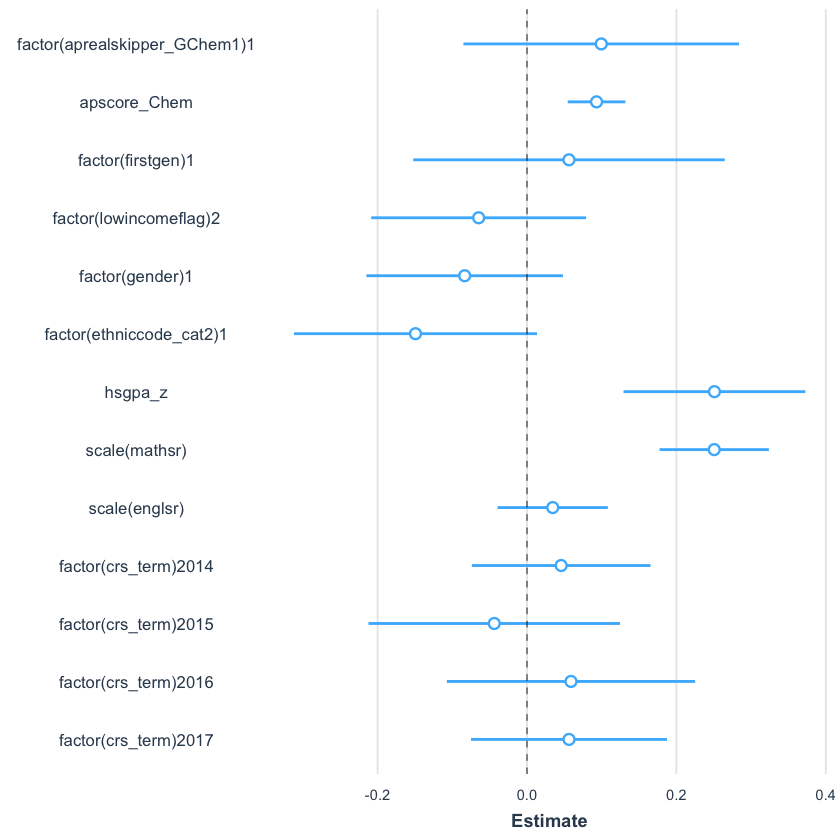

In [0]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2c <- summ(fitchem_2c, confint=T, vifs=T)
chem2c
plot_summs(chem2c, scale=T) #Get coeff. plot with CI, scale=T for easy assessment across var

In [0]:
# 2e. 2nd course grade; everyone, actually skipped
# The weight is the same as 2c (predicting propensity to skip from full dataset)
# Regression to predict grades in CHEM1B: NOT include AP score
#chem.w <- svydesign(ids=~1, weights=get.w(skip_weight), data=chemap_unique_nomiss)
fitchem_2e <- svyglm(numgrade~factor(aprealskipper_GChem1)+
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat2) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chem.w)
coef(fitchem_2e)


(Intercept) factor(aprealskipper_GChem1)1 
                  2.635556947                   0.401959483 
            factor(firstgen)1        factor(lowincomeflag)2 
                  0.043274690                  -0.055067719 
              factor(gender)1      factor(ethniccode_cat2)1 
                 -0.083280347                  -0.132716588 
                      hsgpa_z                 scale(mathsr) 
                  0.260439281                   0.272042677 
                scale(englsr)          factor(crs_term)2014 
                  0.032287651                   0.046334267 
         factor(crs_term)2015          factor(crs_term)2016 
                  0.008465769                   0.154795939 
         factor(crs_term)2017 
                  0.141626659

MODEL INFO:
Observations: 7472
Dependent Variable: numgrade
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.20
Adj. R² = 0.20 

Standard errors: Robust
----------------------------------------------------------------------------------
                                       Est.    2.5%   97.5%   t val.      p    VIF
----------------------------------- ------- ------- ------- -------- ------ ------
(Intercept)                            2.64    2.39    2.88    21.21   0.00       
factor(aprealskipper_GChem1)1          0.40    0.28    0.53     6.35   0.00   1.96
factor(firstgen)1                      0.04   -0.16    0.25     0.41   0.68   2.19
factor(lowincomeflag)2                -0.06   -0.20    0.09    -0.75   0.45   1.40
factor(gender)1                       -0.08   -0.21    0.05    -1.25   0.21   1.61
factor(ethniccode_cat2)1              -0.13   -0.29    0.03    -1.63   0.10   1.34
hsgpa_z                                0.26    0.14    0.38     4.17   0.00   2.34
scale(

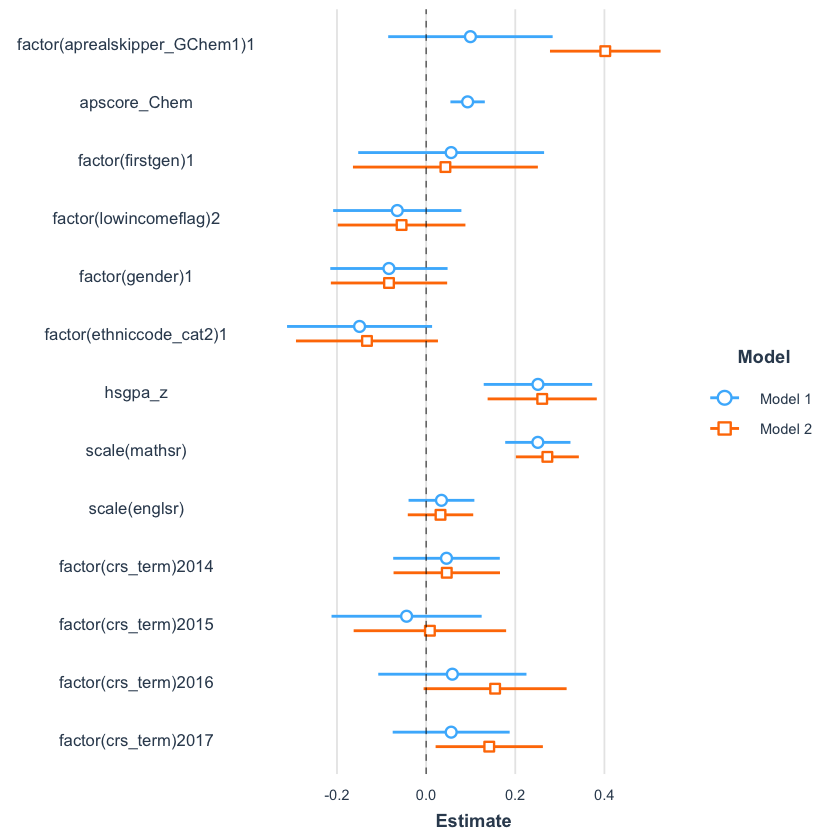

In [0]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2e <- summ(fitchem_2e, confint=T, vifs=T)
chem2e
plot_summs(chem2c, chem2e, scale=T)

In [0]:
# 2g. Skip eligible, full sample
# Repeat the steps for aprealskipper_GChem1
# First, check if covariates are balanced
bal.tab(apskipper_GChem1 ~ factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        ethniccode_cat2 + hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term),
        data = chemap_unique_nomiss, estimand = "ATT", m.threshold = .05) # not really balanced

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Balance Measures
                           Type Diff.Un      M.Threshold.Un
factor(firstgen)_1       Binary -0.2692 Not Balanced, >0.05
factor(firstgen):<NA>    Binary  0.0012     Balanced, <0.05
factor(lowincomeflag)_2  Binary -0.1153 Not Balanced, >0.05
factor(gender)_1         Binary -0.1835 Not Balanced, >0.05
factor(gender):<NA>      Binary  0.0039     Balanced, <0.05
ethniccode_cat2          Binary  0.0107     Balanced, <0.05
hsgpa_z                 Contin.  0.6931 Not Balanced, >0.05
scale(mathsr)           Contin.  1.6460 Not Balanced, >0.05
scale(englsr)           Contin.  1.0284 Not Balanced, >0.05
factor(crs_term)_2013    Binary -0.1946 Not Balanced, >0.05
factor(crs_term)_2014    Binary -0.1802 Not Balanced, >0.05
factor(crs_term)_2015    Binary -0.0409     Balanced, <0.05
factor(crs_term)_2016    Binary  0.2118 Not Balanced, >0.05
factor(crs_term)_2017    Binary  0.2039 Not Balanced, >0.05

Balance tally for mean differences
                    count
Balanced, <0.05      

In [0]:
# Next, calculate weights
skipEl_weight <- weightit(apskipper_GChem1~factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        ethniccode_cat2 + hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), 
                      data=chemap_unique_nomiss, estimand="ATT", method="ps", missing = "saem")
summary(skipEl_weight)

                 Summary of weights

- Weight ranges:

        Min                                 Max
treated   1                         ||    1.000
control   0 |---------------------------| 1.203

- Units with 5 greatest weights by group:
                                         
            61     84    111    124   129
 treated     1      1      1      1     1
          7358   5582   3582   2733  1553
 control 0.778 0.9358 1.1035 1.1047 1.203

- Weight statistics:

        Coef of Var   MAD    Entropy
treated       0.000 0.000      0.000
control       2.874 1.345 -17002.693
overall       3.632 1.479  -8691.605

- Effective Sample Sizes:

            Control Treated
Unweighted 7462.000     161
Weighted    805.698     161

In [0]:
# Is our weight more balanced? Yep
bal.tab(skipEl_weight, m.threshold = .05, disp.v.ratio=T)

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Call
 weightit(formula = apskipper_GChem1 ~ factor(firstgen) + factor(lowincomeflag) + 
    factor(gender) + ethniccode_cat2 + hsgpa_z + scale(mathsr) + 
    scale(englsr) + factor(crs_term), data = chemap_unique_nomiss, 
    method = "ps", estimand = "ATT", missing = "saem")

Balance Measures
                            Type Diff.Adj     M.Threshold V.Ratio.Adj
prop.score              Distance  -0.0119                      1.0493
factor(firstgen)_1        Binary  -0.0083 Balanced, <0.05            
factor(firstgen):<NA>     Binary   0.0029 Balanced, <0.05            
factor(lowincomeflag)_2   Binary  -0.0126 Balanced, <0.05            
factor(gender)_1          Binary   0.0070 Balanced, <0.05            
factor(gender):<NA>       Binary   0.0047 Balanced, <0.05            
ethniccode_cat2           Binary   0.0089 Balanced, <0.05            
hsgpa_z                  Contin.  -0.0182 Balanced, <0.05      0.9205
scale(mathsr)            Contin.  -0.0019 Balanced, <0.05      0.8590
scale

In [0]:
# Calculate models given weights
chemEl.w <- svydesign(ids=~1, weights=get.w(skipEl_weight), data=chemap_unique_nomiss)
fitchem_2g <- svyglm(numgrade~factor(apskipper_GChem1)+
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat2) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chemEl.w)
coef(fitchem_2g)

(Intercept) factor(apskipper_GChem1)1         factor(firstgen)1 
               2.58280263                0.36276695                0.01714616 
   factor(lowincomeflag)2           factor(gender)1  factor(ethniccode_cat2)1 
              -0.05543326               -0.06700034               -0.10131853 
                  hsgpa_z             scale(mathsr)             scale(englsr) 
               0.26740597                0.30241083                0.01750971 
     factor(crs_term)2014      factor(crs_term)2015      factor(crs_term)2016 
               0.04259560                0.03040281                0.09289789 
     factor(crs_term)2017 
               0.15439516

MODEL INFO:
Observations: 7472
Dependent Variable: numgrade
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.21
Adj. R² = 0.21 

Standard errors: Robust
------------------------------------------------------------------------------
                                   Est.    2.5%   97.5%   t val.      p    VIF
------------------------------- ------- ------- ------- -------- ------ ------
(Intercept)                        2.58    2.36    2.80    23.04   0.00       
factor(apskipper_GChem1)1          0.36    0.25    0.47     6.34   0.00   1.71
factor(firstgen)1                  0.02   -0.15    0.19     0.20   0.84   1.84
factor(lowincomeflag)2            -0.06   -0.19    0.08    -0.82   0.41   1.33
factor(gender)1                   -0.07   -0.19    0.05    -1.08   0.28   1.69
factor(ethniccode_cat2)1          -0.10   -0.26    0.06    -1.27   0.20   1.22
hsgpa_z                            0.27    0.15    0.38     4.66   0.00   1.87
scale(mathsr)                      0.30    0.2

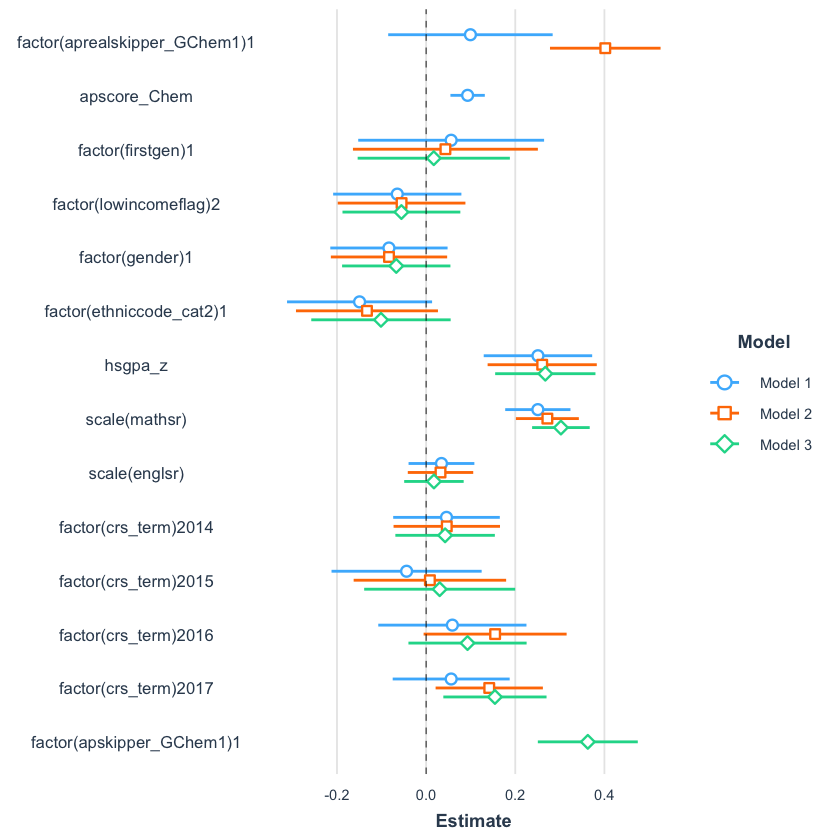

In [0]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2g <- summ(fitchem_2g, confint=T, vifs=T)
chem2g
plot_summs(chem2c, chem2e, chem2g, scale=T) # estimates for covariates are pretty close

In [0]:
# For 2b, 2d, 2f with the AP take sample but use chem_tookap df
# Same analyses: calculate weights with weightit; 
# check for balance using bal.tab, 
# use the weights towards the models, and estimate robust SE/coefficients

In [0]:
####
# Can also think about balance at different AP scores (e.g., 4 or 5) for those eligible
# Because almost all students who were eligible to skip CHEM skipped, let's illustrate with the physics dataset
# sample size is tiny//this is for illustration purpose only
skipEl_phys4 <- subset(physap_unique, apscore_Phys==4)
dim(skipEl_phys4)

[1] 36 52

In [0]:
# Calculate weight
phys.out4 <- weightit(aprealskipper_Phys1~factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat2) + 
                      hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), 
                      data=skipEl_phys4, estimand="ATT", method="ps", missing = "saem")
summary(phys.out4)


                 Summary of weights

- Weight ranges:

           Min                                  Max
treated 1.0000          ||                   1.0000
control 0.3679 |---------------------------| 2.4585

- Units with 5 greatest weights by group:
                                           
              1      4      5      6      7
 treated      1      1      1      1      1
             32     27     21     18     11
 control 1.4061 1.5836 1.8019 2.3541 2.4585

- Weight statistics:

        Coef of Var   MAD Entropy
treated       0.000 0.000   0.000
control       0.489 0.380   4.605
overall       0.361 0.217   5.153

- Effective Sample Sizes:

           Control Treated
Unweighted  15.000      21
Weighted    12.259      21

In [0]:
# Checking balance on the output, set threshold to .05
bal.tab(phys.out4, m.threshold=.05, disp.v.ratio=T)

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Call
 weightit(formula = aprealskipper_Phys1 ~ factor(firstgen) + factor(lowincomeflag) + 
    factor(gender) + factor(ethniccode_cat2) + hsgpa_z + scale(mathsr) + 
    scale(englsr) + factor(crs_term), data = skipEl_phys4, method = "ps", 
    estimand = "ATT", missing = "saem")

Balance Measures
                            Type Diff.Adj         M.Threshold V.Ratio.Adj
prop.score              Distance   0.2911                          2.6508
factor(firstgen)_1        Binary   0.0811 Not Balanced, >0.05            
factor(firstgen):<NA>     Binary   0.0952 Not Balanced, >0.05            
factor(lowincomeflag)_2   Binary   0.1226 Not Balanced, >0.05            
factor(gender)_1          Binary  -0.0236     Balanced, <0.05            
factor(gender):<NA>       Binary  -0.0201     Balanced, <0.05            
factor(ethniccode_cat2)   Binary   0.0041     Balanced, <0.05            
hsgpa_z                  Contin.  -0.2321 Not Balanced, >0.05      1.3774
scale(mathsr)            Contin.  -0

In [0]:
# Regression model
physEl_skip.w <- svydesign(ids=~1, weights=get.w(phys.out4), data=skipEl_phys4)
fitphys_ap4 <- svyglm(numgrade~factor(aprealskipper_Phys1)+
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat2) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=physEl_skip.w)
coef(fitphys_ap4)

(Intercept) factor(aprealskipper_Phys1)1 
                  3.71036813                  -0.52659036 
           factor(firstgen)1       factor(lowincomeflag)2 
                  0.18629585                  -0.25952489 
             factor(gender)1     factor(ethniccode_cat2)1 
                 -0.29462863                  -0.49458832 
                     hsgpa_z                scale(mathsr) 
                  0.30420323                   0.40085480 
               scale(englsr)         factor(crs_term)2016 
                 -0.38698946                  -0.04755844 
        factor(crs_term)2017 
                 -0.14588516

MODEL INFO:
Observations: 33
Dependent Variable: numgrade
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.44
Adj. R² = 0.18 

Standard errors: Robust
---------------------------------------------------------------------------------
                                      Est.    2.5%   97.5%   t val.      p    VIF
---------------------------------- ------- ------- ------- -------- ------ ------
(Intercept)                           3.71    3.06    4.36    11.82   0.00       
factor(aprealskipper_Phys1)1         -0.53   -0.96   -0.10    -2.53   0.02   1.44
factor(firstgen)1                     0.19   -0.40    0.77     0.66   0.51   2.89
factor(lowincomeflag)2               -0.26   -0.95    0.44    -0.77   0.45   5.01
factor(gender)1                      -0.29   -0.92    0.33    -0.98   0.34   1.74
factor(ethniccode_cat2)1             -0.49   -1.10    0.11    -1.69   0.10   2.68
hsgpa_z                               0.30   -0.02    0.63     1.96   0.06   1.56
scale(mathsr)     

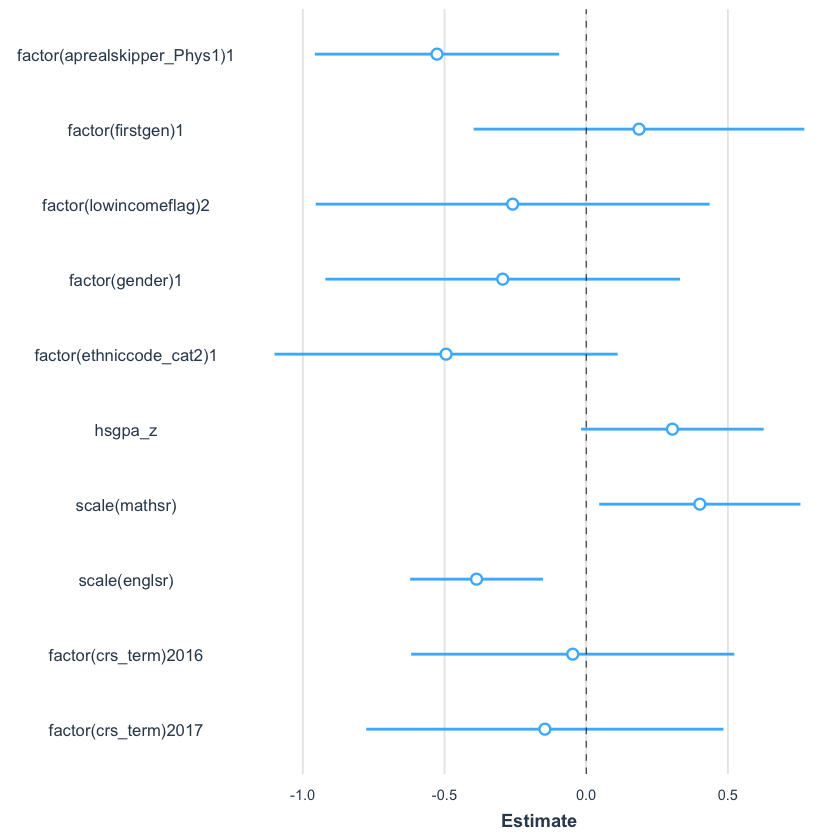

In [0]:
#Obtain robust SE, CI, and VIF with "jtools"
phys_ap4 <- summ(fitphys_ap4, confint=T, vifs=T)
phys_ap4
plot_summs(phys_ap4, scale=T)